In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
import time
import pickle

In [3]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

# MNIST classifer using TensorFlow

This is just a quick example of using the TensorFlow library to train a classifier on the MNIST digits dataset.  I am using a 3-layer model, with 25 "neurons" in the first hidden layer, and 15 in the second.  The model uses a mini-batch approach, with drop-out regularisation.  Final training accuracy is ~98.6%, and ~95.3% accuracy on the hold-out test set.

## Dataset

Load and display the first 10 examples.

In [ ]:
data_df = pd.read_csv('../data/train.csv')

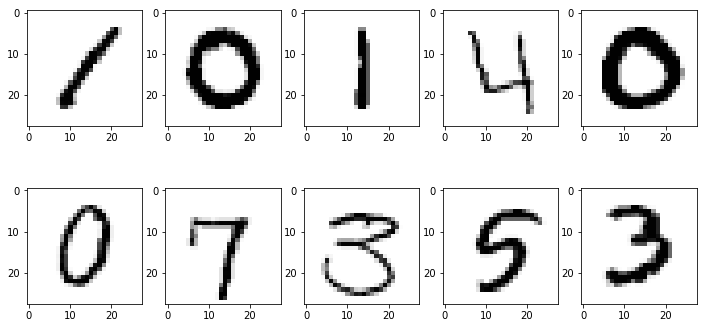

In [23]:
fig, axs = plt.subplots(2,5, figsize=(12,6))
axs = iter(np.ravel(axs))

for i in range(10):
    ax = next(axs)
    img_data = data_df.values[i,1:].reshape(28,28)
    ax.imshow(img_data, cmap='Greys')
    

Put the data into arrays to be used for the training and testing.  Normalize the image values to be between 0 and 1.

In [5]:
Y_full = convert_to_one_hot(data_df.values[:,0], 10)
X_full = data_df.values[:,1:].T/255.

X_train, X_test_cv, Y_train, Y_test_cv = train_test_split(X_full.T, Y_full.T, test_size=0.1)
X_test, X_cv, Y_test, Y_cv = train_test_split(X_test_cv, Y_test_cv, test_size=0.25)

X_train = X_train.T
Y_train = Y_train.T
X_test = X_test.T 
X_cv = X_cv.T
Y_test = Y_test.T
Y_cv = Y_cv.T
print Y_train.shape
print X_train.shape
print Y_test.shape
print X_test.shape

(10, 37800)
(784, 37800)
(10, 3150)
(784, 3150)


In [6]:
X_train = X_train.astype(np.float32, copy=False)
Y_train = Y_train.astype(np.float32, copy=False)
X_test = X_test.astype(np.float32, copy=False)
Y_test = Y_test.astype(np.float32, copy=False)

## Helper functions
These functions are just helper functions used to help set up the model and compute the forward propagation and the cost.

In [7]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, int(num_complete_minibatches) * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, int(num_complete_minibatches) * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [8]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector
    n_y -- scalar, number of classes
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - Use None because it let's us be flexible on the number of examples.
    """
    X = tf.placeholder(tf.float32, name='X', shape=[n_x, None])
    Y = tf.placeholder(tf.float32, name='Y', shape=[n_y, None])
    
    return X, Y

In [9]:
def initialize_parameters(n_L, n_x, n_units_l):
    """
    Initializes parameters to build a neural network with tensorflow.
    
    Arguments:
    n_L = number of layers in the neural network (incl output layer)
    m = number of training examples
    n_units_l = list of len(n_L) where the entries are the corresponding number of units in that layer
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    if len(n_units_l) != n_L:
        raise ValueError, "number of entries in n_units_l must equal the number of layers, n_L"
    
    parameters = {}
    
    for layer in range(n_L):
        n_units = n_units_l[layer]
        if layer==0:
            n_units_prev = n_x
        else:
            n_units_prev = n_units_l[layer-1]
        
        parameters["W"+str(layer+1)] = tf.get_variable("W"+str(layer+1), [n_units, n_units_prev], initializer = tf.contrib.layers.xavier_initializer(), dtype=tf.float32)
        parameters["b"+str(layer+1)] = tf.get_variable("b"+str(layer+1), [n_units,1], initializer = tf.zeros_initializer(), dtype=tf.float32)
       
    return parameters

In [17]:
def compute_relu(W, A, b):
    """Compute LINEAR-> RELU activation"""
    Z = tf.add(tf.matmul(W, A), b) 
    A = tf.nn.relu(Z)
    
    return A

def forward_propagation(X, parameters, n_L, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> ... -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", ... , "W n_L", "b n_L"
                  the shapes are given in initialize_parameters
    keep_prob -- value of the probability of which to keep neurons for the droput regularization (0. to 1.)
    
    Returns:
    ZL -- the output of the last LINEAR unit
    """
    
    for layer in range(n_L):
        
        if layer == 0:
            A_prev = X
        elif layer == n_L-1:
            A_prev = A
        else:
            A_prev = tf.nn.dropout(A, keep_prob)

        if layer != n_L-1:
            A = compute_relu(parameters['W'+str(layer+1)], A_prev, parameters['b'+str(layer+1)])
        else:
            ZL = tf.add(tf.matmul(parameters['W'+str(layer+1)], A_prev), parameters['b'+str(layer+1)])
 
    return ZL

In [11]:
def compute_cost(ZL, Y):
    """
    Computes the cost
    
    Arguments:
    ZL -- output of forward propagation (output of the last LINEAR unit), of shape (n_y, number of examples)
    Y -- "true" labels vector placeholder, same shape as ZL
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

## Model
The model is specified below.  I am using the Adam optimizer for this example.

In [19]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001, n_L = 2, n_units_l = [25,10], 
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements an n_L layer tensorflow neural network: LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set
    Y_train -- training set labels
    X_test -- test set
    Y_test -- test set labels
    learning_rate -- learning rate of the optimization
    n_L -- number of layers (incl. output layer)
    n_units_l -- list of length n_L, containing the number of units at each layer
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    if n_units_l[-1] != n_y:
        n_units_l[-1] = n_y
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    keep_prob = tf.placeholder(tf.float32)
    
    # Initialize parameters
    parameters = initialize_parameters(n_L, n_x, n_units_l)

    # Forward propagation: Build the forward propagation in the tensorflow graph
    ZL = forward_propagation(X, parameters, n_L, keep_prob)

    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(ZL, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Using an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    start_time = time.time()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob:0.9})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost), 'elpased time: %f' %(time.time() - start_time))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(ZL), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train, keep_prob:1.0}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test, keep_prob:1.0}))
        
        return parameters

Run the model for 150 epochs, and output cost function after every 5th epoch.  Cost function vs epoch is plotted below.

('Cost after epoch 0: 1.402347', 'elpased time: 2.721073')
('Cost after epoch 5: 0.371490', 'elpased time: 15.859566')
('Cost after epoch 10: 0.292060', 'elpased time: 29.041337')
('Cost after epoch 15: 0.248021', 'elpased time: 42.179015')
('Cost after epoch 20: 0.228892', 'elpased time: 55.310918')
('Cost after epoch 25: 0.206232', 'elpased time: 68.492206')
('Cost after epoch 30: 0.192013', 'elpased time: 81.616169')
('Cost after epoch 35: 0.182392', 'elpased time: 95.966399')
('Cost after epoch 40: 0.171803', 'elpased time: 110.668569')
('Cost after epoch 45: 0.163627', 'elpased time: 123.787232')
('Cost after epoch 50: 0.157624', 'elpased time: 137.468402')
('Cost after epoch 55: 0.155292', 'elpased time: 151.211953')
('Cost after epoch 60: 0.145957', 'elpased time: 164.759363')
('Cost after epoch 65: 0.143559', 'elpased time: 177.873036')
('Cost after epoch 70: 0.135260', 'elpased time: 190.915718')
('Cost after epoch 75: 0.133756', 'elpased time: 204.029376')
('Cost after epoch 

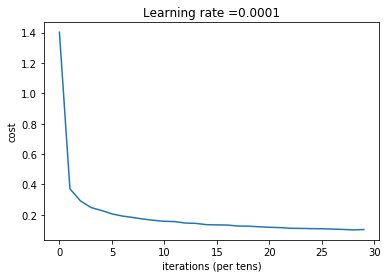

Parameters have been trained!
('Train Accuracy:', 0.9861111)
('Test Accuracy:', 0.95301586)


In [20]:
parameters = model(X_train, Y_train, X_test, Y_test, num_epochs = 150, n_L=3, n_units_l = [25, 15, 10])

Fairly good accuracy is achieved.  

This outputs the parameters, which can then be used to classify new examples.

In [ ]:
with open('../data/tf_parameters.pkl', 'w') as f:
    pickle.dump(parameters, f)